Diagnosing the cause behind the original PINN failure by individually replacing components from my functional recreation

UPDATE: Breakthrough seemed to have come when replacing my model training code. Will make another copy of original and only modify that part

Import statements

In [97]:
import os
import torch
import torchvision
from torch import nn 
from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from torch.utils.data import Dataset
import pyDOE2
from torch.autograd.functional import jacobian, hessian


Variables

In [98]:
x_bounds = [-1, 1]
t_bounds = [0, 1]
n = 200
num_data_points = n
num_collocation_points = 10000
proportion_t_0 = 0.5 #the proportion of the data points which will exist at various points x along the boundary t = 0. The rest will be split between the boundaries x = -1 and x = 1 for all t

Generating Data

In [99]:
def data_generation():
    n = 200 #num data points
    n_collocation = 10000
    t_0_prop = 0.5
    
    np.random.seed(0)

    #boundary data proportions
    t_0_n = (int)(n * t_0_prop)
    x_1_n = (n - t_0_n) // 2
    x_neg_1_n = n - t_0_n - x_1_n

    #generating t = 0 data points with -1 \leq x \leq 1
    t_0_values = np.random.rand(t_0_n) * 2 - 1
    t_0_values = np.column_stack((np.zeros(t_0_n), t_0_values)) #Add a second t dimension that is always 0 (of form t,x)

    #labels of sin(\pi * x) for each x. Generating t = 0 labels
    t_0_label_values = -np.sin(t_0_values[:, 1] * np.pi)

    #generating x = 1 and x = -1 data points with 0 \leq t \leq 1
    x_1_values = np.ones(x_1_n)
    x_neg_1_values = np.ones(x_neg_1_n) * -1
    x_1_neg_1_values = np.hstack((x_1_values, x_neg_1_values))
    x_1_neg_1_values = np.column_stack((np.random.rand(x_1_n + x_neg_1_n), x_1_neg_1_values))

    #label values for x = 1 and x = -1 boundary points
    x_1_neg_1_label_values = np.zeros(x_1_n + x_neg_1_n)

    #concating into input and label arrays
    input_values = np.vstack((t_0_values, x_1_neg_1_values))
    label_values = np.hstack((t_0_label_values, x_1_neg_1_label_values))
    
    return input_values, label_values


data_points, labels = data_generation()


Collocation Points

In [100]:
def lhs_samples(n_collocation): #generate n_collocation points via Latin Hypercube Sampling. Each point is a (t,x)
    lhs_array = pyDOE2.lhs(2, samples=n_collocation) #Two dimensions. Values from 0 to 1
    lhs_array[:,1] = 2*lhs_array[:,1] - 1 #convert range of x values to -1 to 1
    return lhs_array

collocation_points = lhs_samples(num_collocation_points)

Defining the Neural Network

In [101]:
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.act_func = nn.Tanh()
        self.predict = nn.Sequential(
            nn.Linear(2, 20),
            self.act_func,
            nn.Linear(20, 20),
            self.act_func,
            nn.Linear(20, 20),
            self.act_func,
            nn.Linear(20, 20),
            self.act_func,
            nn.Linear(20, 20),
            self.act_func,
            nn.Linear(20, 20),
            self.act_func,
            nn.Linear(20, 20),
            self.act_func,
            nn.Linear(20, 20),
            self.act_func,
            nn.Linear(20, 20),
            self.act_func,
            nn.Linear(20, 1)
        )

    def forward(self, x):
        x = self.predict(x)
        return x


Loss Function

In [102]:
def MSE_f(network, collocation_t, collocation_x):

    u = network(torch.cat((collocation_t, collocation_x), dim=1))

    u_t = torch.autograd.grad(u, collocation_t, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    u_x = torch.autograd.grad(u, collocation_x, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, collocation_x, grad_outputs=torch.ones_like(u_x), retain_graph=True, create_graph=True)[0]

    return torch.mean((u_t + u*u_x - (0.01/torch.pi)*u_xx)**2)
    

    

def criterion(output, labels, collocation_t, collocation_x, network, device):
    loss_u = nn.MSELoss()(output, labels)
    loss_f = MSE_f(network, collocation_t, collocation_x)
    overall_loss = loss_u + loss_f
    return overall_loss, loss_u, loss_f

Model Training

In [103]:
pinn = PINN()
optimizer = torch.optim.LBFGS(pinn.parameters(), #PARAMETERS CREDIT TO https://github.com/teeratornk/PINNs-2/blob/master/Burgers%20Equation/Burgers%20Inference%20(PyTorch).ipynb
                              lr=2,
                              max_iter=50000, 
                                max_eval=50000, 
                                history_size=50,
                                tolerance_grad=1e-5, 
                                tolerance_change=1.0 * np.finfo(float).eps,
                                line_search_fn="strong_wolfe"
                              )

num_epochs = 5

#use the GPU to train if possible, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: " + ("GPU" if torch.cuda.is_available() else "CPU"))
pinn.to(device)

input_data = torch.tensor(data_points.astype(np.float32), requires_grad=True).to(device).view(-1, 2)
label_data = torch.tensor(labels.astype(np.float32), requires_grad=True).to(device).view(-1, 1)
collocation_t = torch.tensor(collocation_points[:,0].astype(np.float32), requires_grad=True).to(device).view(-1, 1)
collocation_x = torch.tensor(collocation_points[:,1].astype(np.float32), requires_grad=True).to(device).view(-1, 1)

i = 0

def closure():
    optimizer.zero_grad() #reset the gradient so that the previous iteration does not affect the current one
    output = pinn(input_data) #run the batch through the current model
    overall_loss, loss_u, loss_f = criterion(output, label_data, collocation_t, collocation_x, pinn, device) #calculate the loss
    overall_loss.backward() #Using backpropagation, calculate the gradients
    #print(f"Avg loss: {loss.item()}")

    global i
    if i%100 == 0:
        print(f"STEP: {i} | Avg Losses | MSE_u: {loss_u.item()} | MSE_f: {loss_f.item()} | Total: {overall_loss.item()}")
    i += 1

    return overall_loss

optimizer.step(closure) #Using the gradients, adjust the parameters   

Using device: CPU
STEP: 0 | Avg Losses | MSE_u: 0.2732499837875366 | MSE_f: 4.7073876885406207e-07 | Total: 0.2732504606246948
STEP: 100 | Avg Losses | MSE_u: 0.06606387346982956 | MSE_f: 0.025897888466715813 | Total: 0.09196176379919052
STEP: 200 | Avg Losses | MSE_u: 0.04709784686565399 | MSE_f: 0.02203916572034359 | Total: 0.06913701444864273
STEP: 300 | Avg Losses | MSE_u: 0.03464261442422867 | MSE_f: 0.01681525819003582 | Total: 0.05145787447690964
STEP: 400 | Avg Losses | MSE_u: 0.025067195296287537 | MSE_f: 0.011761845089495182 | Total: 0.036829039454460144
STEP: 500 | Avg Losses | MSE_u: 0.013152336701750755 | MSE_f: 0.01126962248235941 | Total: 0.02442196011543274
STEP: 600 | Avg Losses | MSE_u: 0.00701700197532773 | MSE_f: 0.007119317073374987 | Total: 0.014136319048702717


KeyboardInterrupt: 

Saving the Code

In [ ]:
base_path = "./"
base_name = "pinn_model"
extension = ".pth"

counter = 0
model_save_path = os.path.join(base_path, base_name + extension)

while os.path.exists(model_save_path):
    counter += 1
    model_save_path = os.path.join(base_path, f"{base_name}_{counter}{extension}")

torch.save(pinn.state_dict(), model_save_path)

print("Model saved!")

Model saved!


Visual Plot

[[0.00744343]
 [0.00760259]
 [0.00718423]
 ...
 [0.00607988]
 [0.00580195]
 [0.00800053]]


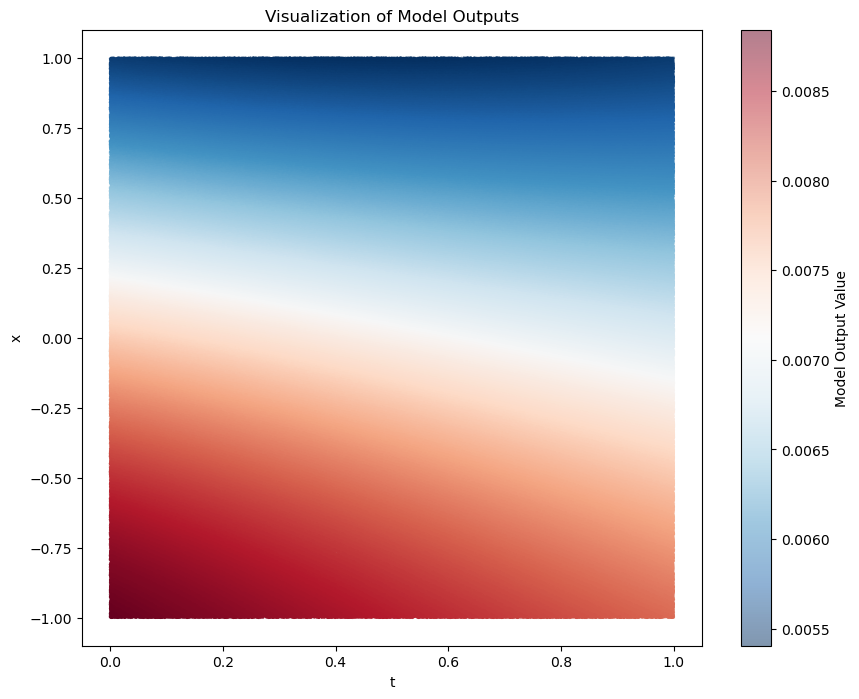

In [ ]:
#Generate Random Points
num_points = 1000000
t_values = np.random.rand(num_points)
x_values = np.random.uniform(-1, 1, num_points)
points = np.vstack((t_values, x_values)).T
points_tensor = torch.tensor(points, dtype=torch.float32).to(device)



#Feed the Points through the Model
with torch.no_grad():
    model_outputs = pinn(points_tensor).cpu().numpy()
    #print(model_outputs)

print(model_outputs[20:])

# Normalize the model outputs to be between 0 and 1 for color mapping
normalized_outputs = (model_outputs - (-1)) / (1 - (-1))


#Plotting
plt.figure(figsize=(10, 8))
plt.scatter(t_values, x_values, c=model_outputs.squeeze(), cmap='RdBu_r', s=1, alpha=0.5)
plt.xlabel("t")
plt.ylabel("x")
plt.colorbar(label='Model Output Value')
plt.title("Visualization of Model Outputs")
plt.show()


Plotting x values again u(x)

In [ ]:
test_n = n

test_input_values = np.random.rand(test_n) * 2 - 1
test_input_values = np.column_stack((np.zeros(test_n), test_input_values)) #Add a second t dimension that is always 0

#labels of sin(\pi * x) for each x in Say
test_label_values = -np.sin(test_input_values[:, 1] * np.pi)


def plot_tensors(x, u, labels):
    # Convert tensors to numpy arrays
    x_np = x
    u_np = u

    # Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(x_np, u_np, color='blue', marker='o', label='u(x)')
    
    if labels is not None:
        labels_np = labels
        plt.scatter(x_np, labels_np, color='red', marker='x', label='Labels')
    
    plt.title('Plot of u(x) and Labels vs. x')
    plt.xlabel('x values')
    plt.ylabel('Values')
    plt.grid(True)
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.axhline(0, color='black',linewidth=0.5)
    plt.axvline(0, color='black',linewidth=0.5)
    plt.legend()
    plt.show()

x = test_input_values[:, 1]
u = network(torch.Tensor(test_input_values.astype(np.float32)).view(-1,2)).detach().numpy()


plot_tensors(x, u, test_label_values)

NameError: name 'network' is not defined